In [205]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()

Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32094 entries, 0 to 32093
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   id_cr                       32094 non-null  int64         
 1   amount                      32094 non-null  float64       
 2   stat_cr                     32094 non-null  object        
 3   created_at                  32094 non-null  datetime64[ns]
 4   user_id                     32094 non-null  int64         
 5   active                      32094 non-null  int64         
 6   moderated_at                21530 non-null  datetime64[ns]
 7   reimbursement_date          4061 non-null   datetime64[ns]
 8   cash_request_received_date  24149 non-null  datetime64[ns]
 9   money_back_date             17204 non-null  datetime64[ns]
 10  transfer_type               32094 non-null  object       

In [206]:
# Filtrar las filas de fees con status "accepted"
#df_jo = df_jo[df_jo['stat_fe'] == 'accepted']

# Filtrar las filas de transfer_type "regular|instant"
#df_jo = df_jo[df_jo['transfer_type'] == 'instant']

# Filtrar para excluir el mes 11-2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]


# Calcular las métricas mensuales
monthly_data = df_jo.groupby('Mes_created_at').agg(
    total_fees=('total_amount', 'sum'),
    total_adelantos=('amount', 'sum')
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

# Mostrar la evolución mensual
print(monthly_data)

   Mes_created_at  total_fees  total_adelantos  fees_ratio
0         2019-11         0.0              1.0    0.000000
1         2019-12         0.0          27297.0    0.000000
2         2020-01         0.0          21587.0    0.000000
3         2020-02         0.0          16653.0    0.000000
4         2020-03         0.0          23549.0    0.000000
5         2020-04         5.0          46093.0    0.010848
6         2020-05      1285.0          94406.0    1.361142
7         2020-06      8725.0         344186.0    2.534967
8         2020-07     10395.0         436097.0    2.383644
9         2020-08     17565.0         446645.0    3.932653
10        2020-09     22935.0         503922.0    4.551300
11        2020-10     43815.0         709233.0    6.177801


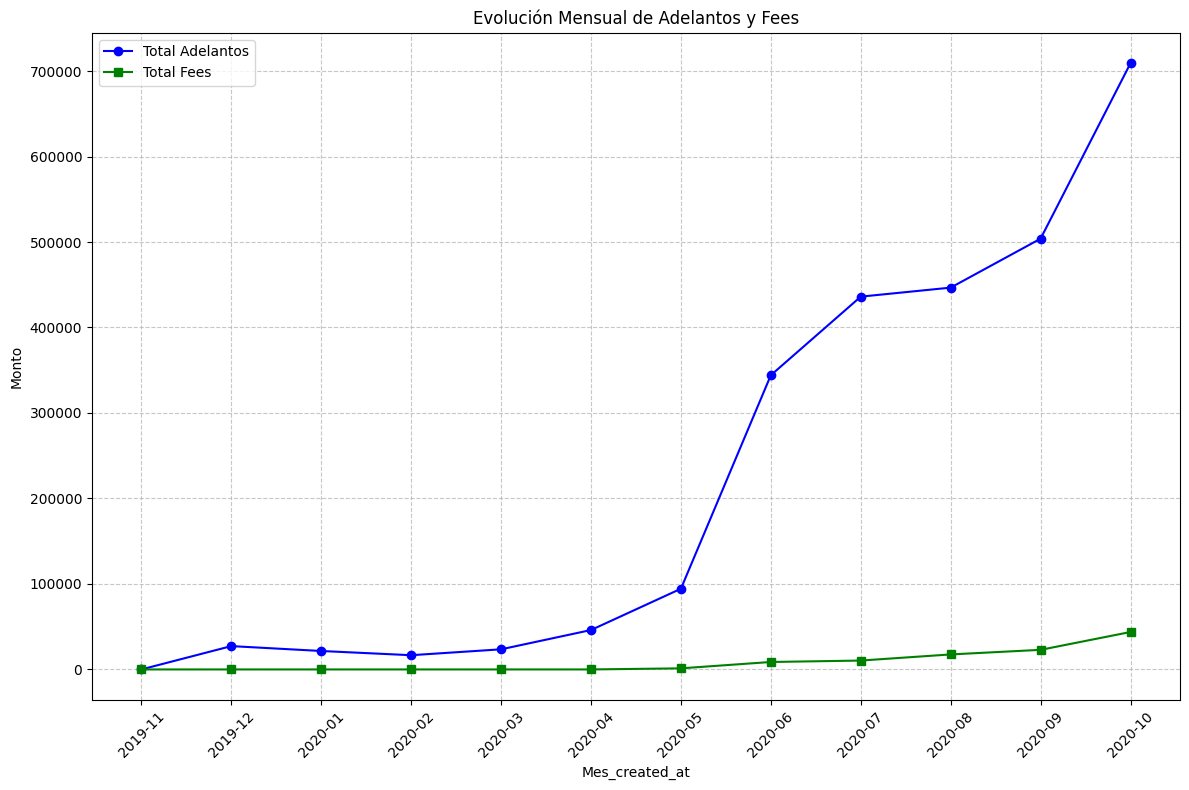

In [207]:
import matplotlib.pyplot as plt

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar adelantos y fees en el mismo eje y
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'
)

# Configurar etiquetas y estilos
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Monto')
ax.set_title('Evolución Mensual de Adelantos y Fees')
ax.legend()  # Mostrar la leyenda para diferenciar las líneas
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



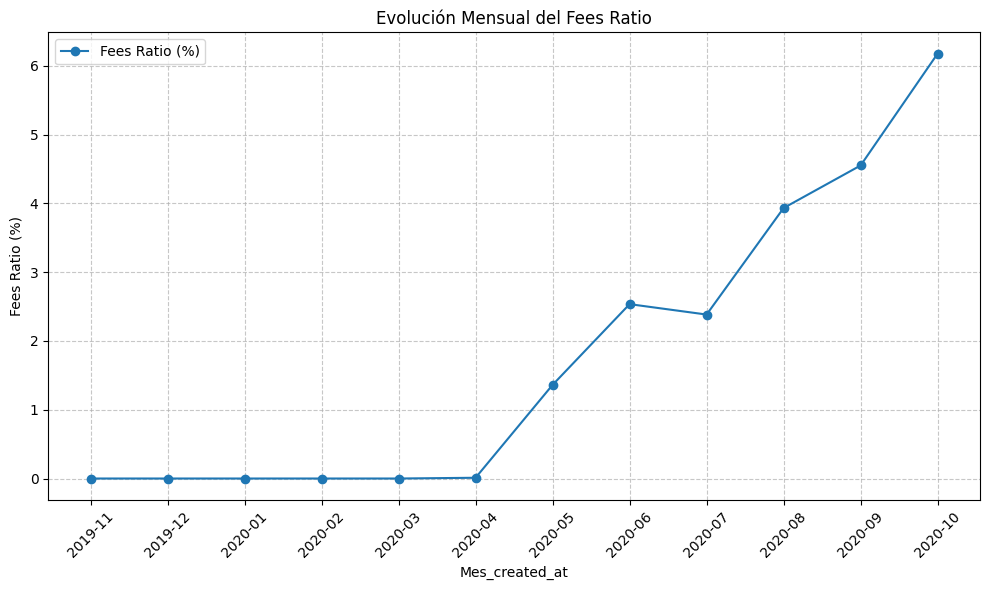

In [208]:
# Plotear la evolución del fees_ratio
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Mes_created_at'].astype(str), monthly_data['fees_ratio'], marker='o', label='Fees Ratio (%)')
plt.title('Evolución Mensual del Fees Ratio')
plt.xlabel('Mes_created_at')
plt.ylabel('Fees Ratio (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

In [209]:
# Calcular las métricas mensuales segregadas por transfer_type
monthly_data = df_jo.groupby(['Mes_created_at', 'transfer_type']).agg(
    total_fees=('total_amount', 'sum'),
    total_adelantos=('amount', 'sum')
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

monthly_data

,Mes_created_at,transfer_type,total_fees,total_adelantos,fees_ratio
0,2019-11,regular,0.0,1.0,0.000000
1,2019-12,regular,0.0,27297.0,0.000000
2,2020-01,regular,0.0,21587.0,0.000000
3,2020-02,regular,0.0,16653.0,0.000000
4,2020-03,regular,0.0,23549.0,0.000000
5,2020-04,regular,5.0,46093.0,0.010848
6,2020-05,regular,1285.0,94406.0,1.361142
7,2020-06,regular,8725.0,344186.0,2.534967
8,2020-07,instant,1390.0,40669.0,3.417837
9,2020-07,regular,9005.0,395428.0,2.277279


In [210]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
#cr['Cohorte'] = cr.groupby('user_id')['created_at_notz'].transform('min').dt.to_period('M')
df_jo.head(10)

/var/folders/jx/l1rhn9z13pn7sj46s794rbsh0000gp/T/ipykernel_13298/2107005953.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')


,id_cr,amount,stat_cr,created_at,user_id,active,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,...,Mes_created_at,type,stat_fe,category,total_amount,paid_at,from_date,to_date,charge_moment,Cohorte
0,5,100.0,rejected,2019-12-10 19:05:21.596873,804,1,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaT,NaT,...,2019-12,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2019-12
1,70,100.0,rejected,2019-12-10 19:50:12.347780,231,1,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaT,NaT,...,2019-12,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2019-12
2,7,100.0,rejected,2019-12-10 19:13:35.825460,191,1,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaT,NaT,...,2019-12,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2019-12
3,10,99.0,rejected,2019-12-10 19:16:10.880172,761,1,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaT,NaT,...,2019-12,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2019-12
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,7686,1,2020-05-07 09:21:55.320193,NaT,NaT,NaT,...,2020-05,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-05
5,2145,100.0,money_back,2020-05-23 20:58:55.129432,9489,1,2020-05-24 12:40:33.054910,NaT,2020-05-26,2020-07-06 03:36:03.023521,...,2020-05,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-05
6,3512,100.0,rejected,2020-06-16 17:07:38.452652,14631,1,2020-06-17 10:21:21.360742,NaT,NaT,NaT,...,2020-06,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-06
7,654,100.0,rejected,2020-02-10 01:11:53.808270,9900309,0,2020-02-10 09:11:21.350695,2020-03-11 01:11:53.807930,NaT,NaT,...,2020-02,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-01
8,5672,100.0,canceled,2020-06-28 12:06:33.712840,9902499,0,NaT,NaT,NaT,NaT,...,2020-06,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2020-06
9,71,90.0,rejected,2019-12-10 19:51:23.911206,897,1,2019-12-12 15:06:11.190299,2019-12-17 19:51:23.910748,NaT,NaT,...,2019-12,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaN,2019-12


In [211]:
# Agrupar los datos por cohorte y mes para calcular las métricas mensuales
cohort_sizes_monthly = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(
    Num_Clientes=('user_id', 'nunique'),  # Número de clientes únicos por cohorte y mes
    Num_Solicitudes=('id_cr', 'nunique'),  # Total de solicitudes únicas por cohorte y mes
    Solicitudes_Instant=('transfer_type', lambda x: (x == 'instant').sum()),  # Solicitudes tipo 'instant' por cohorte y mes
    Solicitudes_Regular=('transfer_type', lambda x: (x == 'regular').sum()),  # Solicitudes tipo 'regular' por cohorte y mes
    Clientes_con_fees=('total_amount', lambda x: (x > 0).sum()),  # Clientes con fees por cohorte y mes
    CR=('amount', 'sum'),  # Total de adelantos por cohorte y mes
    Fees=('total_amount', 'sum'),  # Total de fees por cohorte y mes
    # Contar las líneas con 'stat_fe' == 'accepted'
    paid_fees=('stat_fe', lambda x: (x == 'accepted').sum()),  
    # Contar las líneas con 'stat_fe' != 'accepted'
    non_paid_fees=('stat_fe', lambda x: (x != 'accepted').sum()),
    # Sumar 'total_amount' cuando 'stat_fe' == 'accepted'
    total_paid_fees=('total_amount', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
    # Sumar 'total_amount' cuando 'stat_fe' != 'accepted'
    total_non_paid_fees=('total_amount', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'accepted'].sum())
).reset_index()

# Calcular los porcentajes de non_paid_fees
cohort_sizes_monthly['paid_fees_percent_qty'] = (cohort_sizes_monthly['paid_fees'] / (cohort_sizes_monthly['paid_fees'] + cohort_sizes_monthly['non_paid_fees']))
cohort_sizes_monthly['paid_fees_percent_amount'] = (cohort_sizes_monthly['total_paid_fees'] / cohort_sizes_monthly['Fees'])   # % en monto

# Eliminar las columnas de pago y no pago
cohort_sizes_monthly = cohort_sizes_monthly.drop(
    ['paid_fees', 'non_paid_fees', 'total_paid_fees', 'total_non_paid_fees'], axis=1, errors='ignore')

# Mostrar los resultados de las cohortes por mes
cohort_sizes_monthly


,Cohorte,Mes_created_at,Num_Clientes,Num_Solicitudes,Solicitudes_Instant,Solicitudes_Regular,Clientes_con_fees,CR,Fees,paid_fees_percent_qty,paid_fees_percent_amount
0,2019-11,2019-11,1,1,0,1,0,1.0,0.0,0.000000,NaN
1,2019-11,2019-12,1,1,0,1,0,100.0,0.0,0.000000,NaN
2,2019-11,2020-04,1,1,0,1,0,100.0,0.0,0.000000,NaN
3,2019-11,2020-05,1,1,0,5,5,50.0,25.0,0.200000,0.200000
4,2019-11,2020-08,1,1,2,0,2,20.0,10.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
68,2020-08,2020-09,291,342,433,59,351,35520.0,1755.0,0.514228,0.720798
69,2020-08,2020-10,245,279,310,29,283,26710.0,1415.0,0.678466,0.812721
70,2020-09,2020-09,1988,2220,3157,204,2378,263957.0,11890.0,0.488545,0.690496
71,2020-09,2020-10,679,727,866,70,845,65520.0,4225.0,0.677350,0.750296


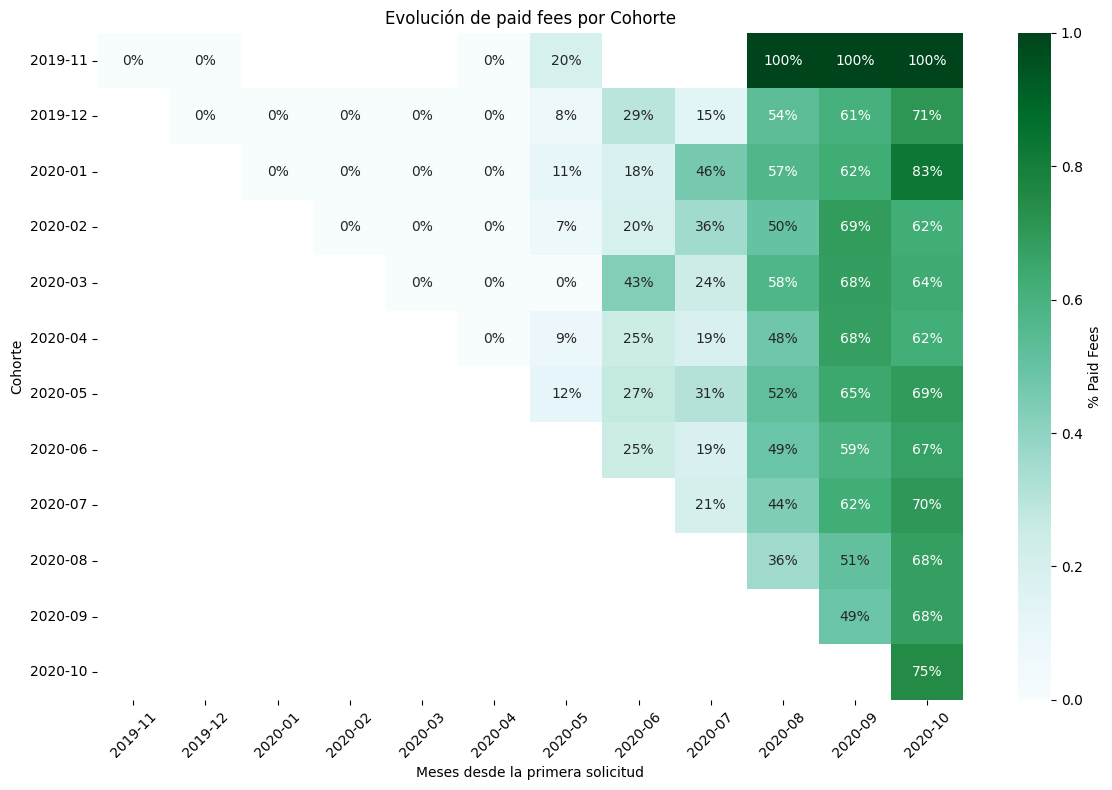

In [212]:
# Pivot the data to create a matrix of LTV per cohort for each month
ltv_heatmap_data = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='paid_fees_percent_qty')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(ltv_heatmap_data, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': '% Paid Fees'})

# Add labels and title
plt.title('Evolución de paid fees por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Show the heatmap
plt.tight_layout()
plt.show()

In [213]:
cohort_ltv_monthly = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(
    Total_Fees=('total_amount', 'sum'),  
    Clientes=('user_id', 'nunique')  # Clientes únicos para calcular el LTV
).reset_index()


# Calcular el LTV mensual
cohort_ltv_monthly['LTV_Mensual'] = cohort_ltv_monthly['Total_Fees'] / cohort_ltv_monthly['Clientes']
cohort_ltv_monthly

,Cohorte,Mes_created_at,Total_Fees,Clientes,LTV_Mensual
0,2019-11,2019-11,0.0,1,0.000000
1,2019-11,2019-12,0.0,1,0.000000
2,2019-11,2020-04,0.0,1,0.000000
3,2019-11,2020-05,25.0,1,25.000000
4,2019-11,2020-08,10.0,1,10.000000
...,...,...,...,...,...
68,2020-08,2020-09,1755.0,291,6.030928
69,2020-08,2020-10,1415.0,245,5.775510
70,2020-09,2020-09,11890.0,1988,5.980885
71,2020-09,2020-10,4225.0,679,6.222386


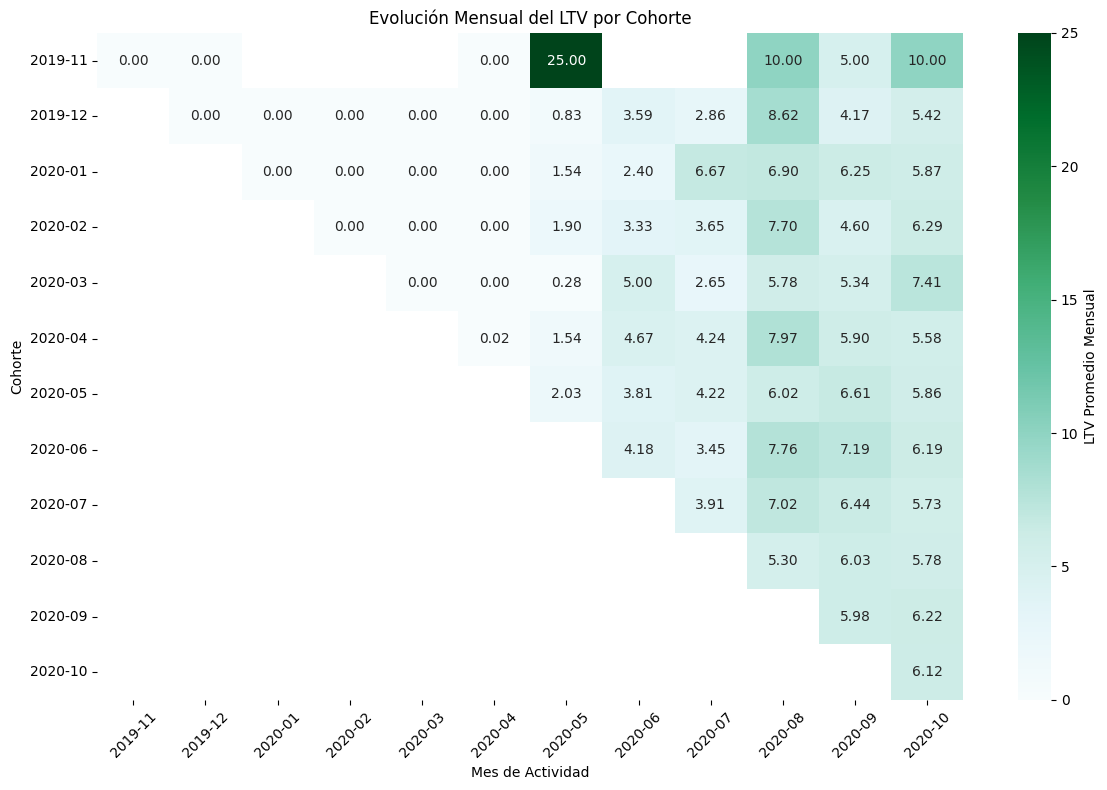

In [214]:
# Reorganizar los datos en una matriz para el heatmap
ltv_matrix = cohort_ltv_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='LTV_Mensual')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=ltv_matrix, annot=True, fmt='.2f', cmap='BuGn', cbar_kws={'label': 'LTV Promedio Mensual'})
plt.title('Evolución Mensual del LTV por Cohorte')
plt.xlabel('Mes de Actividad')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [215]:
# Analisis de cohortes para cada mes
cohort_sizes_monthly = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(Num_Clientes=('user_id', 'nunique')).reset_index()
cohort_sizes_monthly

,Cohorte,Mes_created_at,Num_Clientes
0,2019-11,2019-11,1
1,2019-11,2019-12,1
2,2019-11,2020-04,1
3,2019-11,2020-05,1
4,2019-11,2020-08,1
...,...,...,...
68,2020-08,2020-09,291
69,2020-08,2020-10,245
70,2020-09,2020-09,1988
71,2020-09,2020-10,679


In [216]:
# Calcular la tasa de retención de clientes (clientes únicos por cohorte en cada mes / clientes iniciales de la cohorte)
retention_clientes = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='Num_Clientes')
retention_clientes = retention_clientes.div(cohort_sizes_initial.set_index('Cohorte')['Num_Clientes_Iniciales'], axis=0)
retention_clientes

Mes_created_at,2019-11,2019-12,2020-01,2020-02,2020-03,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10
Cohorte,,,,,,,,,,,,
2019-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.178694,2.426117,1.759450,1.817869


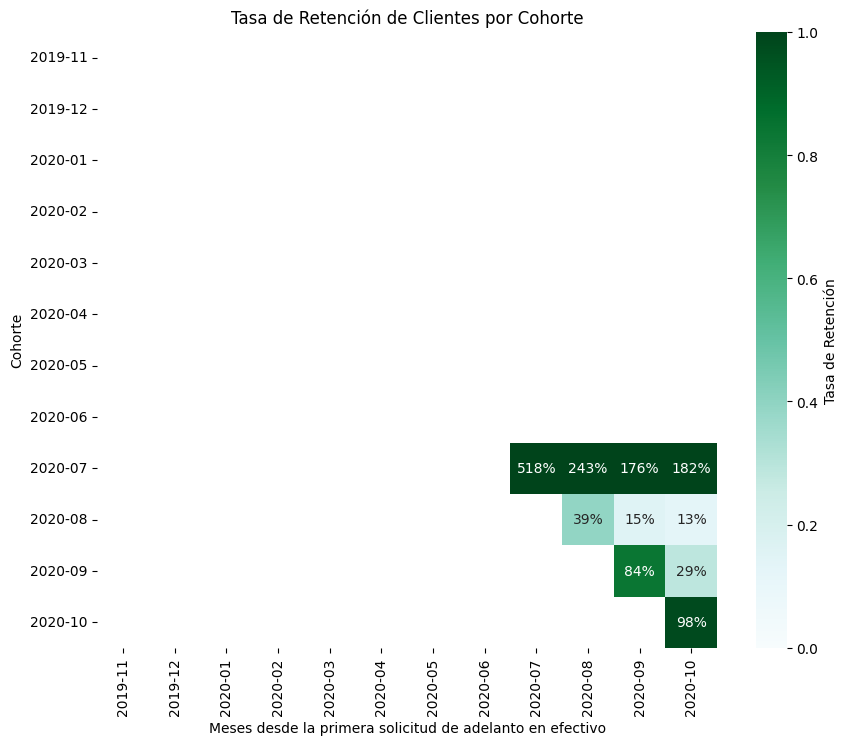

In [217]:
# Visualizar la tasa de retención de clientes usando un mapa de calor
plt.figure(figsize=(10, 8))
plt.title('Tasa de Retención de Clientes por Cohorte')
sns.heatmap(data=retention_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': 'Tasa de Retención'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()

In [218]:
# Calcular la tasa de abandono de clientes (1 - tasa de retención)
churn_clientes = 1 - retention_clientes


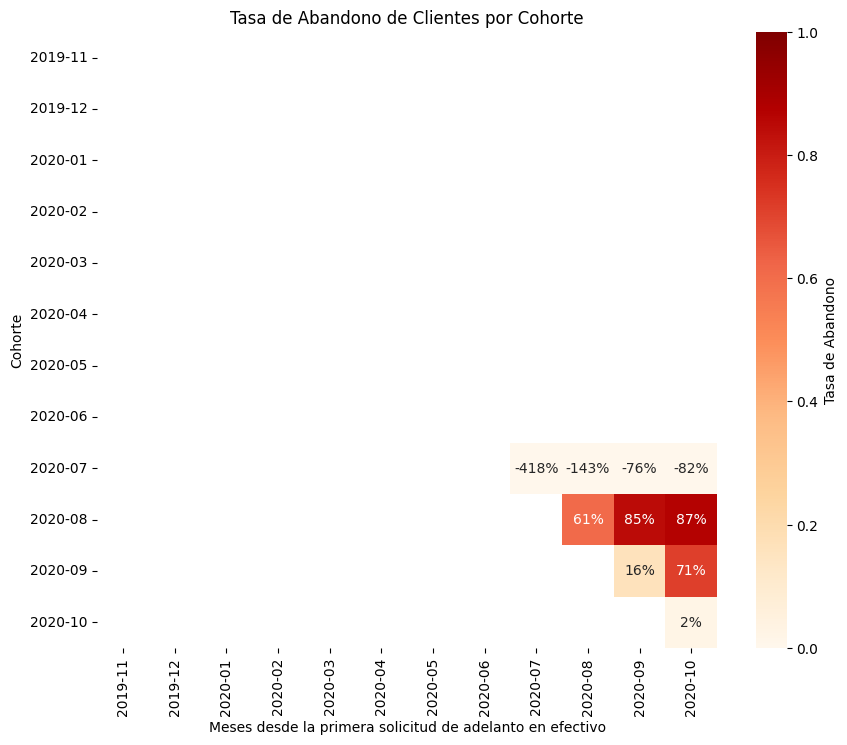

In [219]:

plt.figure(figsize=(10, 8))
plt.title('Tasa de Abandono de Clientes por Cohorte')
sns.heatmap(data=churn_clientes, annot=True, fmt='.0%', vmin=0.0, vmax=1.0,cmap='OrRd', cbar_kws={'label': 'Tasa de Abandono'})
plt.xlabel('Meses desde la primera solicitud de adelanto en efectivo')
plt.ylabel('Cohorte')
plt.show()